<a href="https://www.kaggle.com/code/locpham2001/titanic-numbers-from-disaster?scriptVersionId=97884932" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(rc = {'figure.figsize':(15,8)})
plt.rcParams['savefig.dpi'] = 200

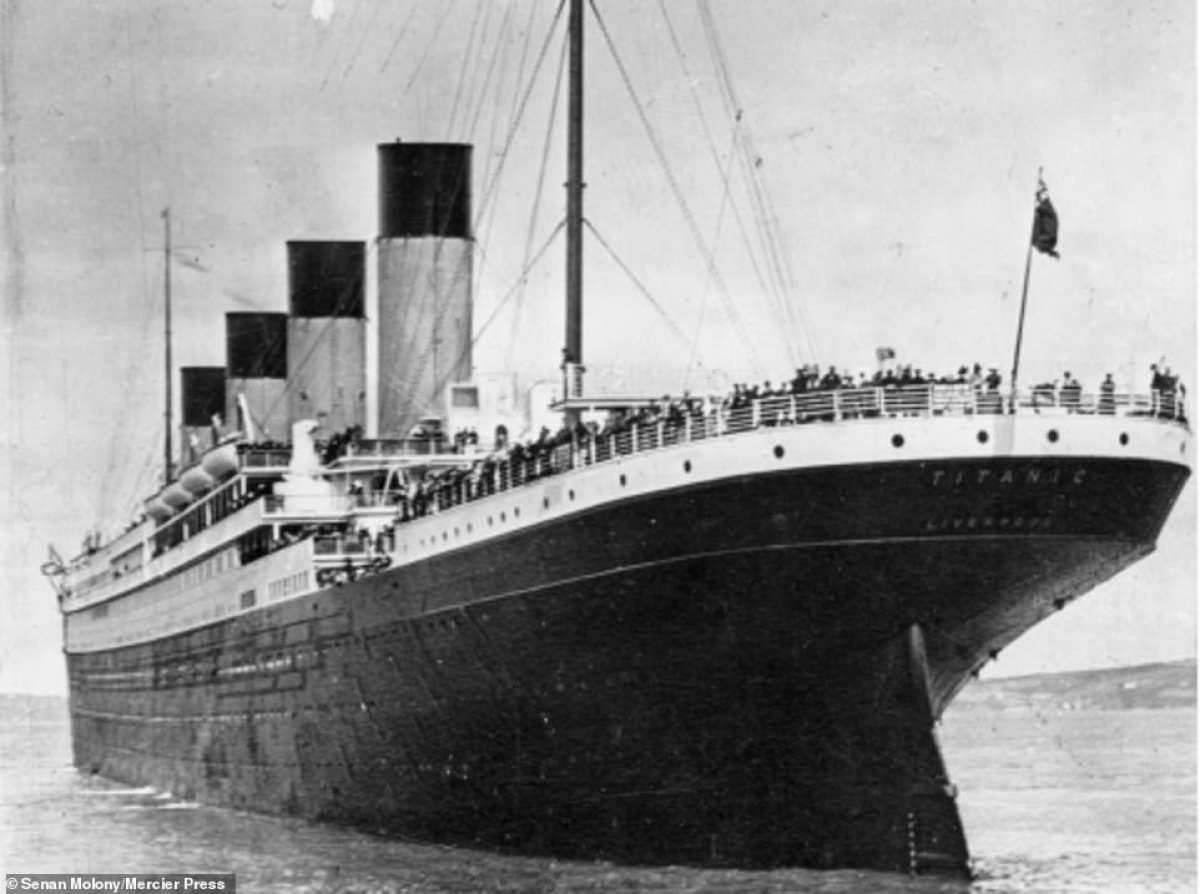

# 1. Load data

In [2]:
train = pd.read_csv(r'../input/titanic/train.csv')
test = pd.read_csv(r'../input/titanic/test.csv')
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# set index to PassengerID
train = train.set_index("PassengerId")
test = test.set_index("PassengerId")

In [4]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (891, 11)
Test shape:  (418, 10)


In [5]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

Notice that **Age, Cabin, Fare and Embarked** have some missing values.. We need to deal with them.

In [7]:
train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
Pclass,891.0,2.31,0.84,1.00,2.00,3.00,3.0,3.00
Age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
SibSp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
Parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
Fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


# 2. Missing values

**Concat train, test to whole dataset for convenient**

In [8]:
data=pd.concat([train, test])
print(data.shape)

(1309, 11)


> ## 2.1 Age

**We need to replace all null ages based on title and average age by title.**

In [9]:
print("Number of null ages:", data["Age"].isnull().sum())

Number of null ages: 263


In [10]:
def fill_age(data):
    
    # Frist, extract title from names
    data['Initial']=0
    for i in data:
        data['Initial'] = data["Name"].str.extract('([A-Za-z]+)\.')
    
    # Second, replace them to Mr, Mrs, Miss or Other
    data["Initial"] = data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col',
                                               'Rev','Capt','Sir','Don', 'Dona'],
                                              ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other',
                                               'Mr','Mr','Mr', 'Mrs']
                                             )
    
    # Third,compute the average age of each title.
    age_mean = data.groupby('Initial')['Age'].mean().map(np.ceil)
    
    # Finally, assign the null values with the ceil values of the mean age.
    for idx, val in zip(age_mean.index, age_mean.values):
        for i in data:
            data.loc[(data["Age"].isnull())&(data["Initial"]==idx),"Age"] = val
    
    return data

In [11]:
data = fill_age(data=data)
print("Is there any null value for age? -", data.Age.isnull().any())

Is there any null value for age? - False


> ## 2.2 Embarked 

In [12]:
print("Number of null embarked:", data["Embarked"].isnull().sum())

Number of null embarked: 2


In [13]:
data["Embarked"].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Note: (C = Cherbourg; Q = Queenstown; S = Southampton)   
Most of passengers came from Southampton, we can simply replace missing values of **"Embarked"** to **"S"**

In [14]:
data.loc[data["Embarked"].isnull(), "Embarked"] = "S"
print("Is there any null value for embarked? -", data.Embarked.isnull().any())

Is there any null value for embarked? - False


> ## 2.3 Fare

In [15]:
print("Number of null fare:", data["Fare"].isnull().sum())

Number of null fare: 1


Simply replace null values of fare with average...

In [16]:
data.loc[data["Fare"].isnull(), "Fare"] = data.Fare.mean().round(4)
print("Is there any null value for embarked? -", data.Embarked.isnull().any())

Is there any null value for embarked? - False


> ## 2.4. Cabin

In [17]:
print("Number of null 'cabin':", data["Cabin"].isnull().sum())
# Look at various type of cabins
print(data["Cabin"].value_counts())

Number of null 'cabin': 1014
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64


I'll accept null values for cabins..

**Now, I'll split the whole data to train set and test set as before.**

In [18]:
# Convert some columns to int
data[["Pclass","Age","SibSp","Parch"]] = data[["Pclass","Age","SibSp","Parch"]].astype("int64")

# Split to train and test again..
train = data[data.index.isin(train.index)]
test  = data[data.index.isin(test.index)]

# Check
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (891, 12)
Test shape:  (418, 12)


# 3. EDA

In [19]:
color = "#5580cc"
palette=["#eb4255", "#2f9286"]

> ## 3.1. Survived percentage

In [20]:
train['Survived'] = train['Survived'].astype("int64")

Text(0, 0.5, '')

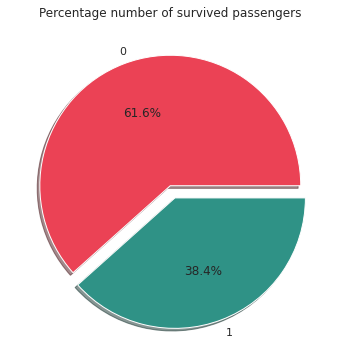

In [21]:
fig ,ax = plt.subplots(1,1,figsize=(6,6))

train['Survived'].value_counts().plot.pie(explode=[0,0.1],
                                          autopct='%1.1f%%',
                                          ax=ax,
                                          colors = palette,
                                          center = (10,0),
                                          shadow=True)

ax.set_title('Percentage number of survived passengers')
ax.set_ylabel('')

> ## 3.2 Sex and Age

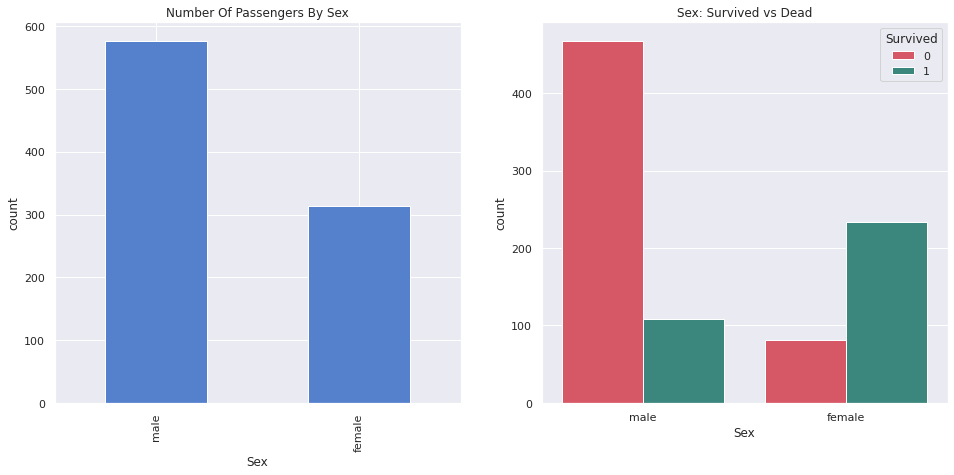

In [22]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
train['Sex'].value_counts().plot.bar(color="#5580cc",ax=ax[0], xlabel="Sex")
ax[0].set_title('Number Of Passengers By Sex')
ax[0].set_ylabel('count')
sns.countplot('Sex', hue='Survived', data=train, ax=ax[1], palette=palette)
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

Text(0.5, 1.0, 'Distribution of age among Alive people')

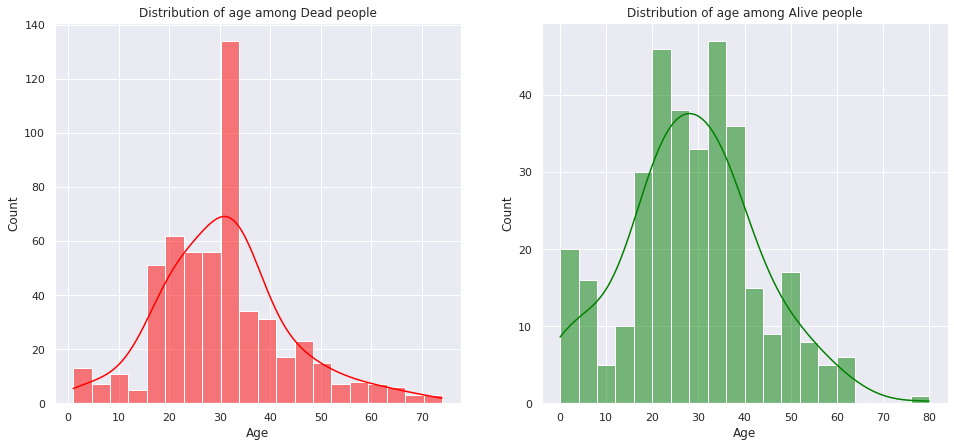

In [23]:
fig,ax = plt.subplots(1,2,figsize=(16,7))

# Dead
sns.histplot(data=train[train['Survived']==0],
             x='Age',bins=20,
             kde=True,
             kde_kws=dict(bw_adjust=1.5),
             legend=True,
             color='red',
             ax=ax[0])
ax[0].set_title("Distribution of age among Dead people")

# Alive
sns.histplot(data=train[train['Survived']==1],
             x='Age',bins=20,
             kde=True,
             kde_kws=dict(bw_adjust=1.5),
             legend=True,
             color='green',
             ax=ax[1])
ax[1].set_title("Distribution of age among Alive people")

Text(0.5, 1.0, 'Female passengers')

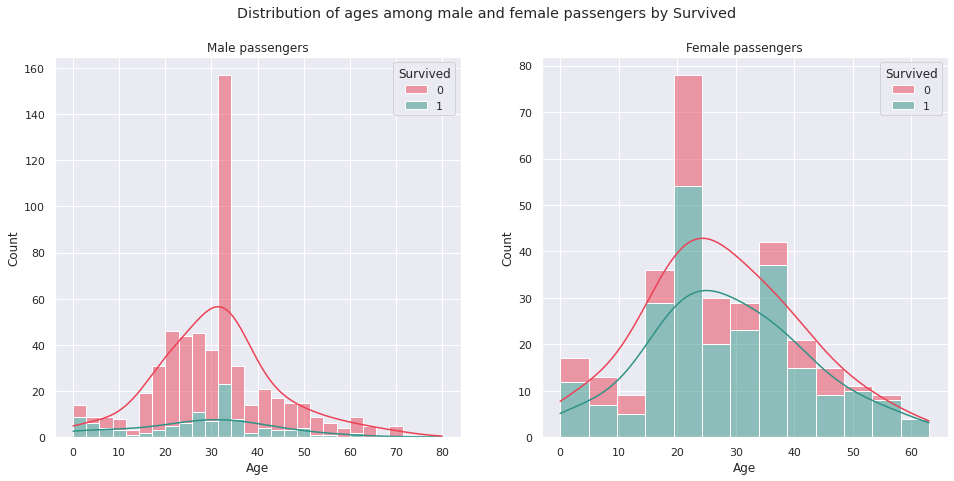

In [24]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
plt.suptitle("Distribution of ages among male and female passengers by Survived")

sns.histplot(x='Age', hue='Survived',
             data=train[train["Sex"]=="male"],
             multiple='stack',
             kde=True,
             kde_kws = dict(bw_adjust=1.5),
             ax=ax[0], palette=palette
            )

ax[0].set_title("Male passengers")

sns.histplot(x='Age', hue='Survived',
             data=train[train["Sex"]=="female"],
             multiple='stack',
             kde=True,
             kde_kws = dict(bw_adjust=1.5),
             ax=ax[1], palette=palette
            )

ax[1].set_title("Female passengers")

> ## 3.3 Title

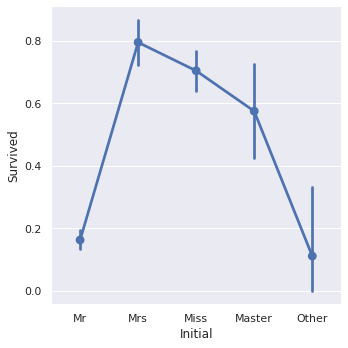

In [25]:
sns.factorplot('Initial','Survived', data=train);

> ## 3.4 Passenger class 

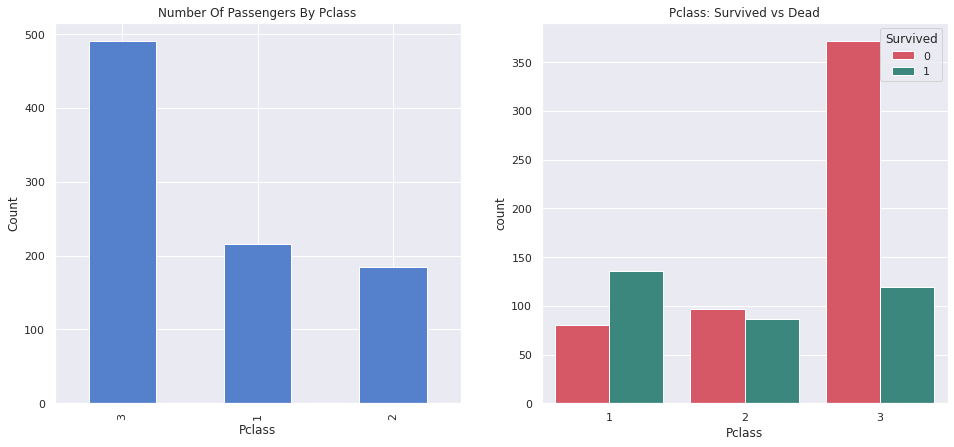

In [26]:
fig ,ax=plt.subplots(1,2,figsize=(16,7))
train['Pclass'].value_counts().plot.bar(color="#5580cc",ax=ax[0], xlabel="Pclass")
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=train,ax=ax[1], palette=palette)
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

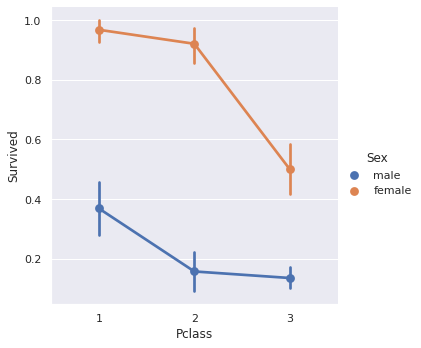

In [27]:
sns.factorplot(data=train, x='Pclass', y='Survived',hue='Sex')

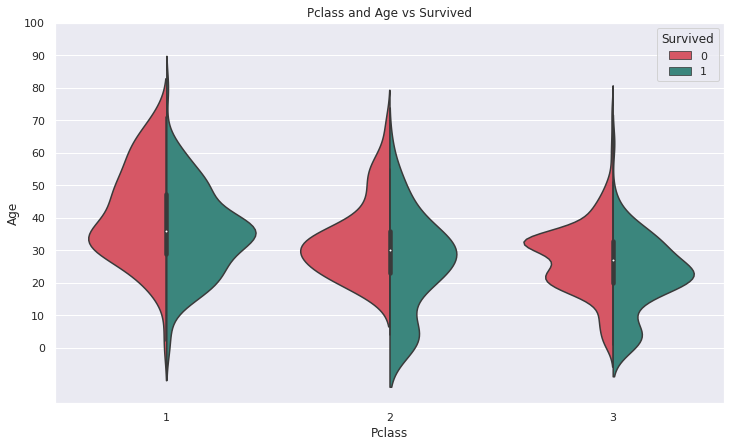

In [28]:
fig,ax=plt.subplots(1,1,figsize=(12,7))

sns.violinplot(x="Pclass", y="Age",
               hue="Survived",
               data=train,
               split=True,
               ax=ax, palette=palette
              )

ax.set_title('Pclass and Age vs Survived')
ax.set_yticks(range(0,110,10));

> ## 3.5 Embarked 

<AxesSubplot:xlabel='Embarked', ylabel='count'>

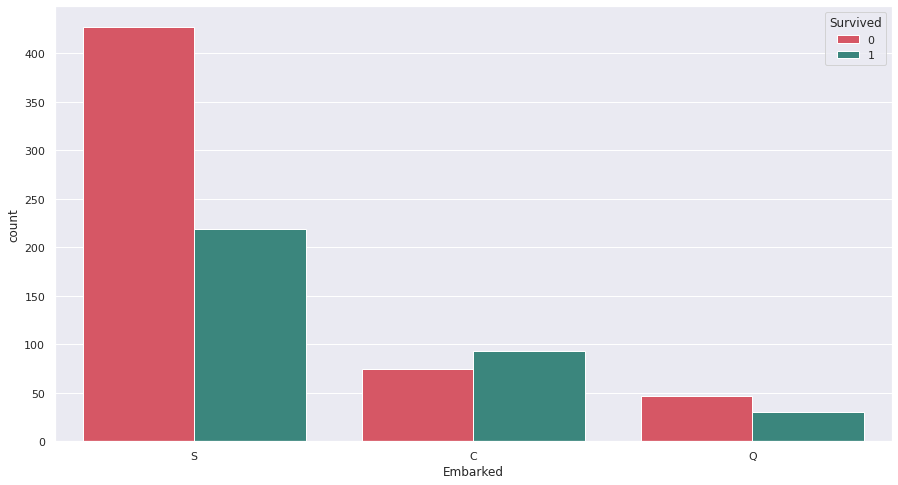

In [29]:
sns.countplot(data=train, x='Embarked',hue='Survived', palette = palette)

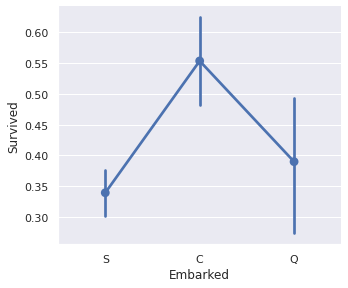

In [30]:
sns.factorplot('Embarked','Survived',data=train);
fig = plt.gcf()
fig.set_size_inches(5,4);

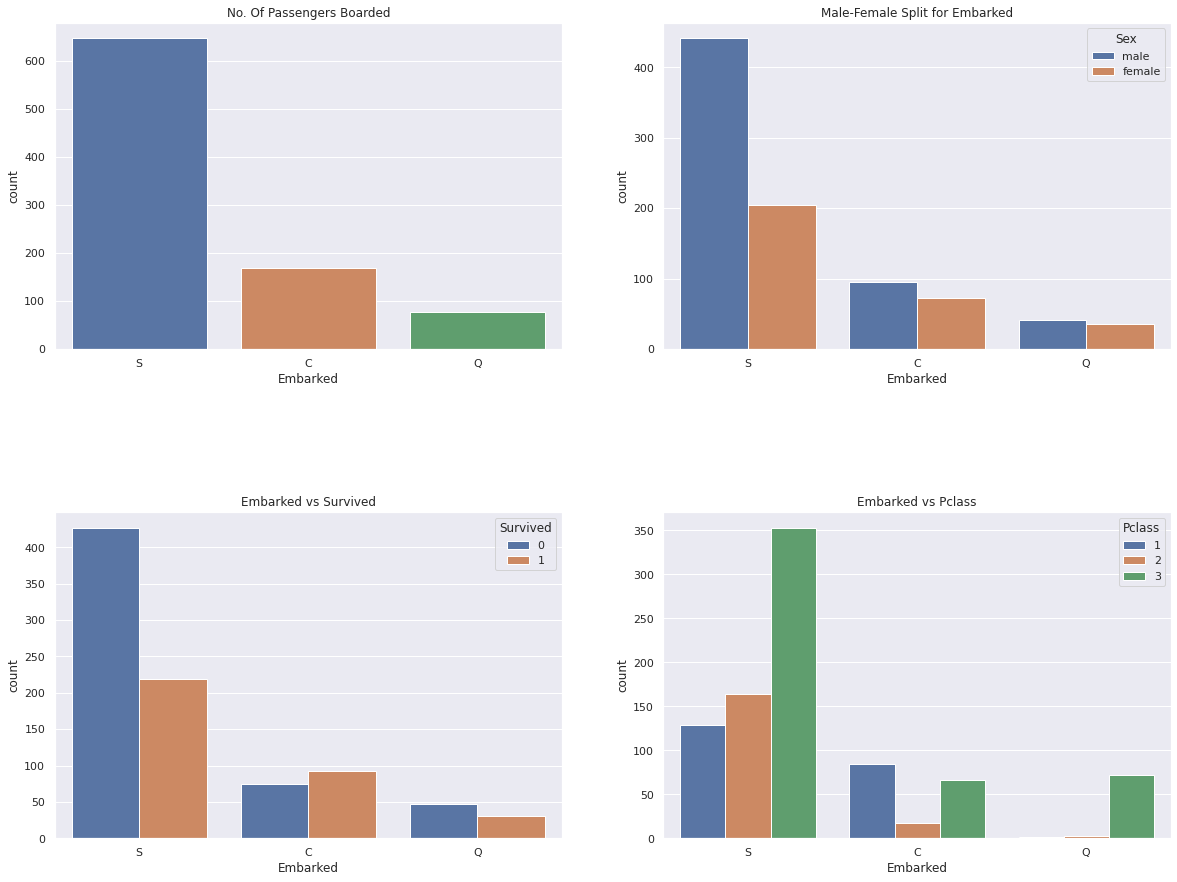

In [31]:
fig, ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=train,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=train,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=train,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=train,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

> ## 3.6 SibSp & Parch

Note:   
**sibsp** -> Number of Siblings/Spouses Aboard

**parch** -> Number of Parents/Children Aboard

Text(0.5, 0.98, 'Survived and Sibling/Spouses aboard')

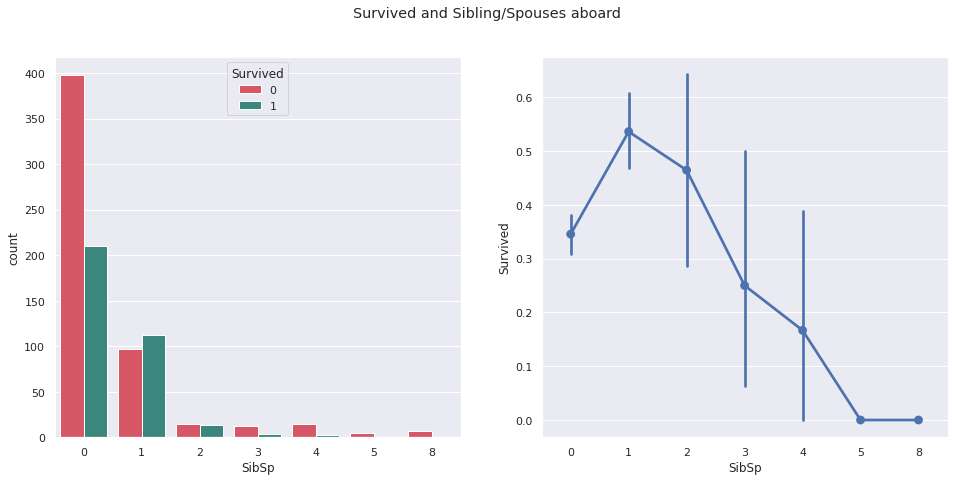

In [32]:
fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='SibSp', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('SibSp','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and Sibling/Spouses aboard")

Text(0.5, 0.98, 'Survived and Parent/Child aboard')

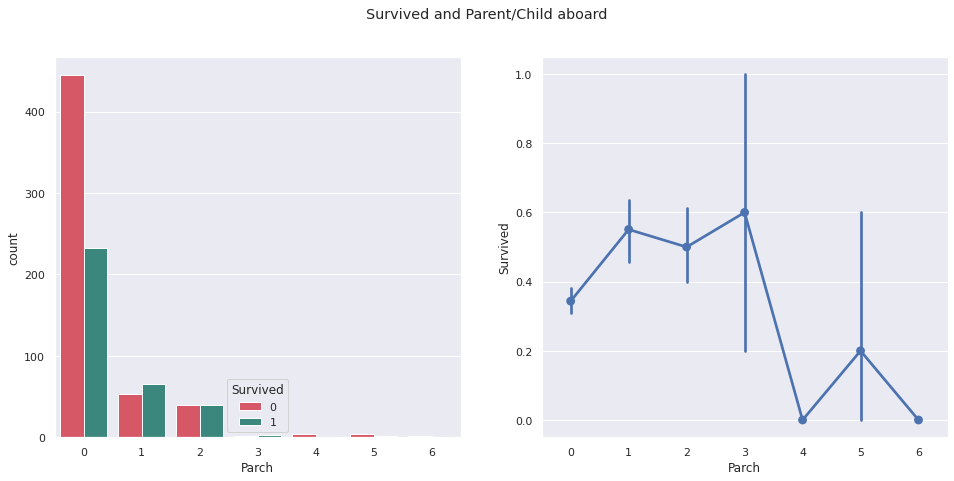

In [33]:
fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='Parch', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('Parch','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and Parent/Child aboard")

Text(0.5, 0.98, 'Survived and family size')

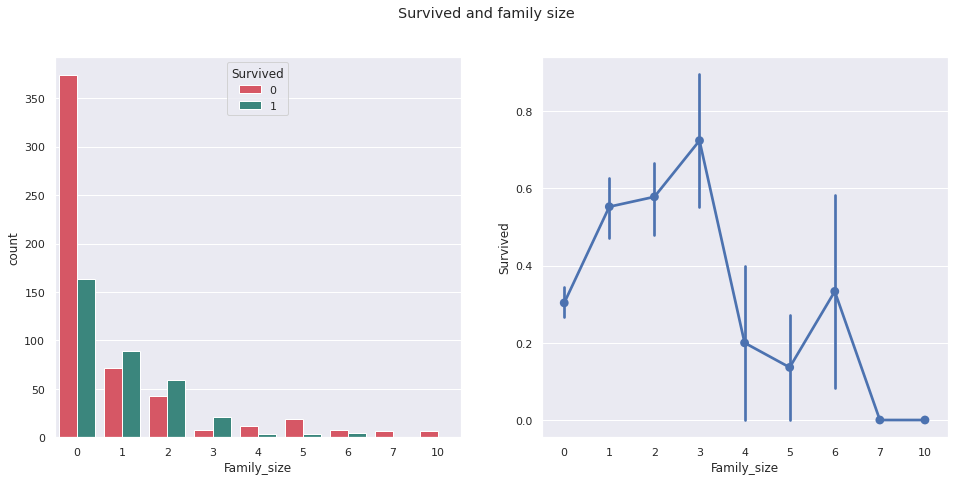

In [34]:
train["Family_size"] = train["SibSp"] + train["Parch"]

fig, ax=plt.subplots(1,2,figsize=(16,7))

sns.countplot(x='Family_size', hue='Survived', data=train, palette=palette, ax=ax[0])
sns.pointplot('Family_size','Survived',data=train, ax=ax[1]);

plt.suptitle("Survived and family size")

> ## 3.7 Fare

In [35]:
print('Highest Fare was:',train['Fare'].max())
print('Lowest Fare was:',train['Fare'].min())
print('Average Fare was:',train['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


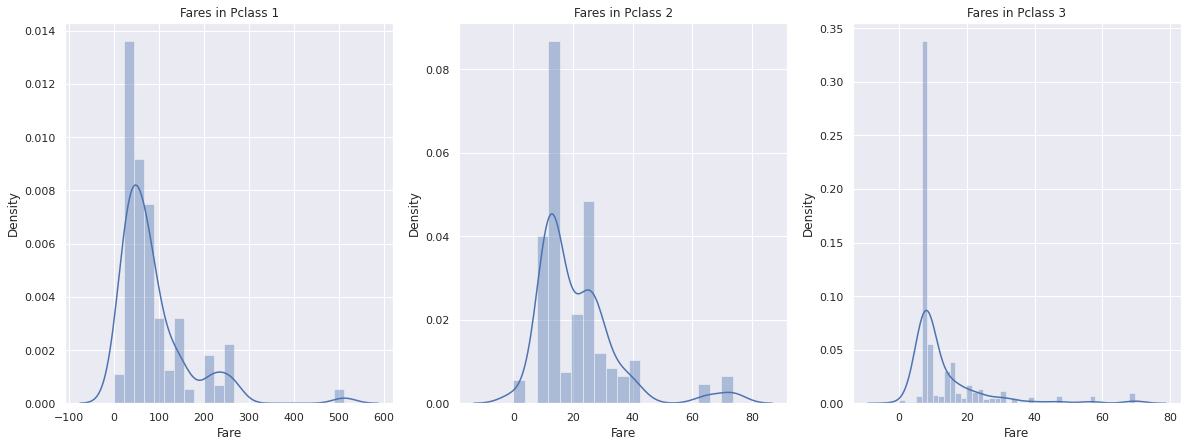

In [36]:
f,ax=plt.subplots(1,3,figsize=(20,7))
sns.distplot(data[data['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(data[data['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(data[data['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

Text(0.5, 1.0, 'Box-plot of fare by Survived')

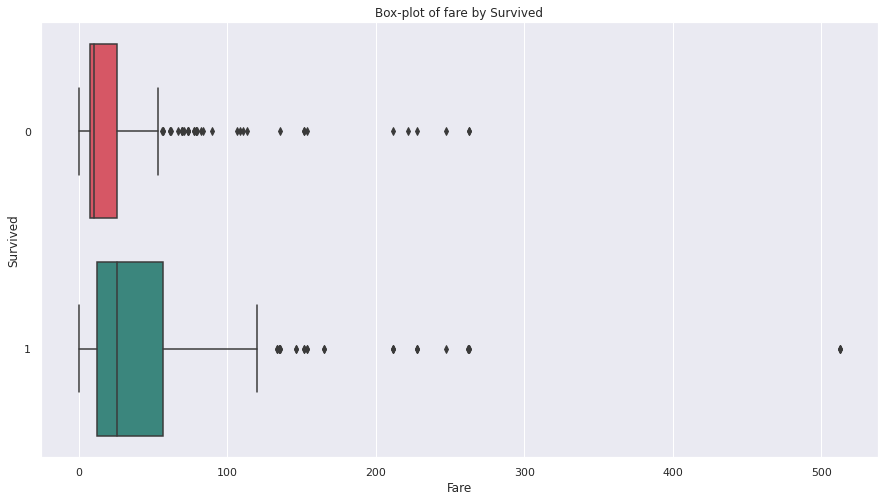

In [37]:
sns.boxplot(y="Survived", x="Fare",
            data=train,
            orient = 'h',
            palette=palette)

plt.title("Box-plot of fare by Survived")

# 4. Build model

> ## 4.1 Encoding

In [38]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'],[0,1,2,3,4],inplace=True)

In [39]:
data["Family_size"] = data["SibSp"] + data["Parch"]

In [40]:
df = data.copy()
df.drop(['Name','Ticket','Cabin', 'SibSp', 'Parch'],axis=1,inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Initial,Family_size
PassengerId,,,,,,,,
1,0.0,3,0,22,7.2500,0,0,1
2,1.0,1,1,38,71.2833,1,1,1
3,1.0,3,1,26,7.9250,0,2,0
4,1.0,1,1,35,53.1000,0,1,1
5,0.0,3,0,35,8.0500,0,0,0


In [41]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

minmax_scaler = MinMaxScaler()
df["Age"] = minmax_scaler.fit_transform(df["Age"].values.reshape(-1, 1))

rb_scaler = RobustScaler()
df["Fare"] = rb_scaler.fit_transform(df["Fare"].values.reshape(-1, 1))

In [42]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Initial,Family_size
PassengerId,,,,,,,,
1,0.0,3,0,0.2750,-0.308146,0,0,1
2,1.0,1,1,0.4750,2.430755,1,1,1
3,1.0,3,1,0.3250,-0.279274,0,2,0
4,1.0,1,1,0.4375,1.652999,0,1,1
5,0.0,3,0,0.4375,-0.273927,0,0,0


In [43]:
df_train = df[df.index.isin(train.index)]
df_test  = df[df.index.isin(test.index)]
df_test.drop("Survived", axis=1, inplace=True)

print("Train shape: ", df_train.shape)
print("Test shape: ", df_test.shape)

Train shape:  (891, 8)
Test shape:  (418, 7)


In [44]:
X = df_train.drop('Survived',axis=1)
y = df_train["Survived"] 

In [45]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.model_selection import cross_val_score, train_test_split 

# Importing metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #for confusion matrix
from sklearn.metrics import accuracy_score, classification_report, roc_curve

# Tuning hyperparameters
from sklearn.model_selection import GridSearchCV

In [46]:
X_train,X_val, y_train,y_val = train_test_split(X, y, test_size=0.25, random_state=42)

print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_val.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_val.shape)

The shape of X_train is       (668, 7)
The shape of X_test is        (223, 7)
The shape of y_train is       (668,)
The shape of y_test is        (223,)


In [47]:
logr_model = LogisticRegression(C=10)
logr_model.fit(X, y)
y_pred = logr_model.predict(X_val)
print("========Logistic Regression output=========\n")
print(classification_report(y_val, y_pred))

========Logistic Regression output=========

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       134
         1.0       0.78      0.72      0.75        89

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223



In [48]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       134
         1.0       0.74      0.75      0.74        89

    accuracy                           0.79       223
   macro avg       0.78      0.79      0.79       223
weighted avg       0.79      0.79      0.79       223



In [49]:
knn = KNeighborsClassifier(10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       134
         1.0       0.76      0.74      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



In [50]:
# Try an ensemble model - Voting Classifier
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('logr', logr_model),
                                    ('knn', knn), ('gnb', gnb)], voting='hard')

eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       134
         1.0       0.75      0.74      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



In [51]:
# Try another ensemble model - GradientBoosting Classifier

from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86       134
         1.0       0.81      0.73      0.77        89

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



Surprisingly, the accuracy score and F1-Score of **GBC** with default parameters was actually well compared to those models before.   
Next, I'll try tuning some important parameters to increase **Accuracy Score**.

In [56]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.4,1],
    "max_depth":[2,4,8,10],
    "max_features":["log2","sqrt"],
    "n_estimators":[20,30,50,70,100]
    }

#passing the scoring function in the GridSearchCV
clf = GridSearchCV(gbc,
                   param_grid=parameters,
                   scoring="accuracy",
                   cv=5,
                   verbose=1
                  )

clf.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.4, 1],
                         'max_depth': [2, 4, 8, 10],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [20, 30, 50, 70, 100]},
             scoring='accuracy', verbose=1)

In [58]:
clf.best_score_

0.8383346425765907

In [59]:
df_test["Survived"] = clf.predict(df_test)

In [60]:
output = df_test["Survived"]

In [61]:
output.to_csv("./output.csv")